In [ ]:
!pip install apyori

In [ ]:
pip install PyARMViz


In [2]:
import pandas as pd 
import numpy as np
import networkx as nx 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
from PyARMViz.Rule import Rule

import missingno as msno
from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [5]:
df = pd.read_csv('/kaggle/input/the-bread-basket/bread basket.csv')
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [7]:
df['Transaction'].nunique()

9465

In [14]:
df['date_time']=pd.to_datetime(df['date_time'])
df['date']=df['date_time'].dt.date
df['time']=df['date_time'].dt.time
df['month']=df['date_time'].dt.month

/tmp/ipykernel_105/229260557.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time']=pd.to_datetime(df['date_time'])


In [15]:
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend,date,time,month
0,1,Bread,2016-10-30 09:58:00,morning,weekend,2016-10-30,09:58:00,10
1,2,Scandinavian,2016-10-30 10:05:00,morning,weekend,2016-10-30,10:05:00,10
2,2,Scandinavian,2016-10-30 10:05:00,morning,weekend,2016-10-30,10:05:00,10
3,3,Hot chocolate,2016-10-30 10:07:00,morning,weekend,2016-10-30,10:07:00,10
4,3,Jam,2016-10-30 10:07:00,morning,weekend,2016-10-30,10:07:00,10


In [18]:
df['month'] = df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                                  ('January','February','March','April','May','June','July','August',
                                   'September','October','November','December'))
df['day'] = df['date_time'].dt.weekday
df['day'] = df['day'].replace((0,1,2,3,4,5,6), 
                              ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
df['hour'] = df['date_time'].dt.hour
df.drop('date_time', axis=1, inplace=True)
df.head()


,Transaction,Item,period_day,weekday_weekend,date,time,month,day,hour
0,1,Bread,morning,weekend,2016-10-30,09:58:00,October,Sunday,9
1,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,Sunday,10
2,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,Sunday,10
3,3,Hot chocolate,morning,weekend,2016-10-30,10:07:00,October,Sunday,10
4,3,Jam,morning,weekend,2016-10-30,10:07:00,October,Sunday,10


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

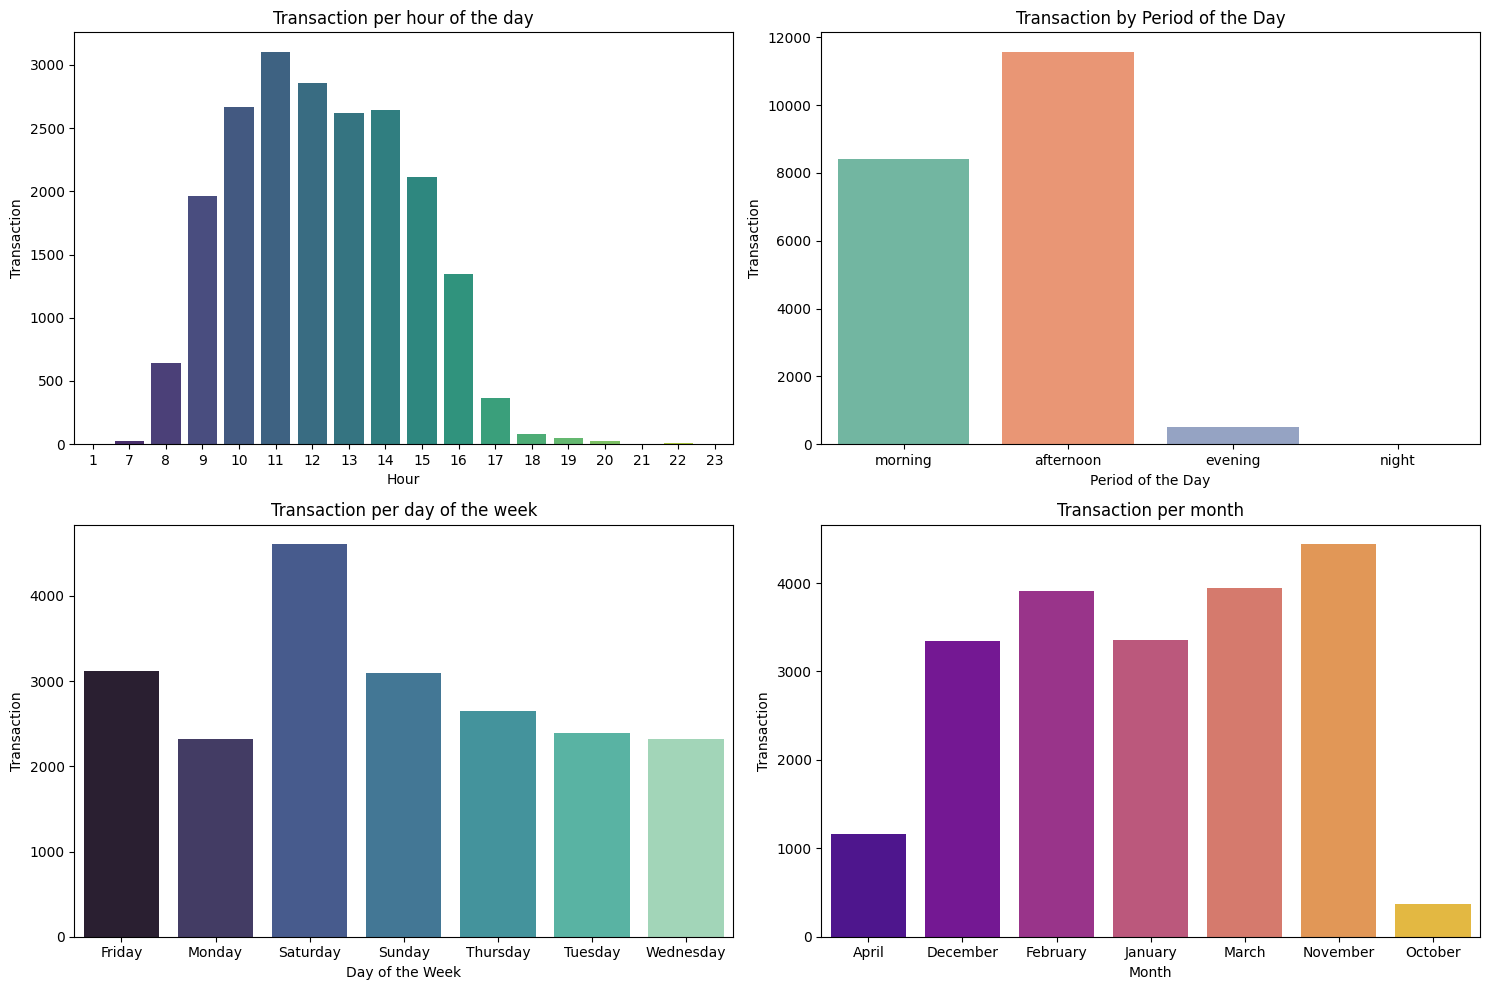

In [24]:
# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Transaction per hour of the day
count_by_hour = df.groupby('hour')['Transaction'].count().reset_index()
count_by_hour.sort_values('hour', inplace=True)
sns.barplot(x=count_by_hour['hour'], y=count_by_hour['Transaction'], ax=axs[0, 0], palette='viridis')
axs[0, 0].set(xlabel='Hour', ylabel='Transaction', title='Transaction per hour of the day')

# Plot 2: Transaction by period of the day
count_by_weekday = df['period_day'].value_counts().reindex(['morning', 'afternoon', 'evening', 'night'])
sns.barplot(x=count_by_weekday.index, y=count_by_weekday.values, ax=axs[0, 1], palette='Set2')
axs[0, 1].set(xlabel='Period of the Day', ylabel='Transaction', title='Transaction by Period of the Day')

# Plot 3: Transaction per day of the week
count_by_day = df.groupby('day')['Transaction'].count().reset_index()
count_by_day.sort_values('day', inplace=True)
sns.barplot(x=count_by_day['day'], y=count_by_day['Transaction'], ax=axs[1, 0], palette='mako')
axs[1, 0].set(xlabel='Day of the Week', ylabel='Transaction', title='Transaction per day of the week')

# Plot 4: Transaction per month
count_by_month = df.groupby('month')['Transaction'].count().reset_index()
count_by_month.sort_values('month', inplace=True)
sns.barplot(x=count_by_month['month'], y=count_by_month['Transaction'], ax=axs[1, 1], palette='plasma')
axs[1, 1].set(xlabel='Month', ylabel='Transaction', title='Transaction per month')

# Adjust layout
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


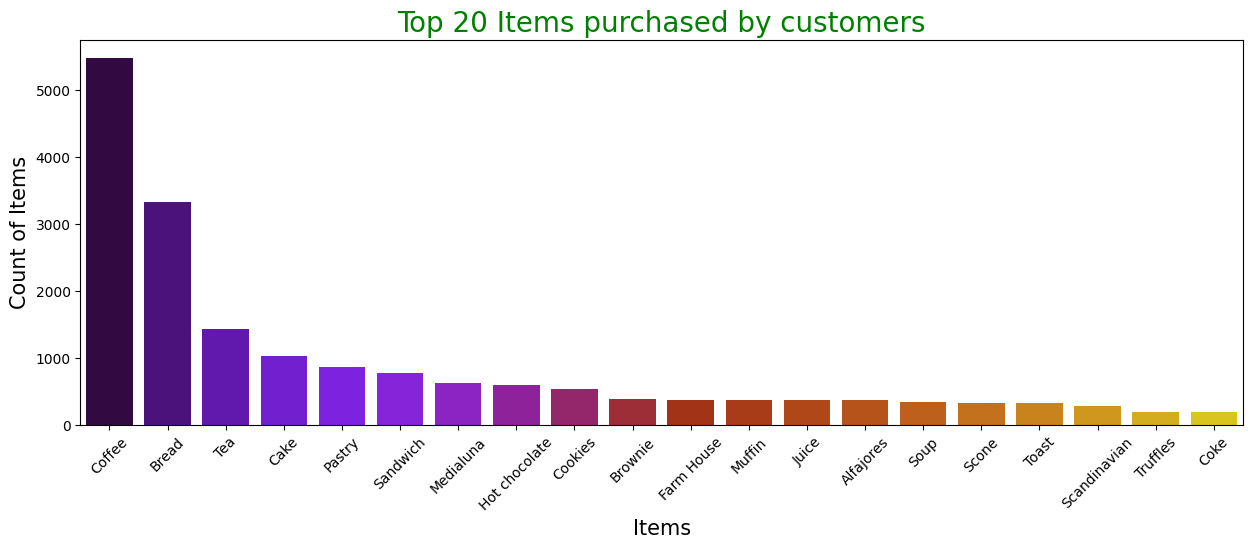

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(x = df.Item.value_counts().head(20).index, y = df.Item.value_counts().head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 15)
plt.title('Top 20 Items purchased by customers', color = 'green', size = 20)
plt.show()

Apriori algorithm

In [32]:
from mlxtend.frequent_patterns import association_rules, apriori
transactions = df.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name ='Count')
transactions_sorted = transactions.sort_values(by='Count', ascending=True)
transactions_sorted

,Transaction,Item,Count
12284,6486,Hot chocolate,1
12292,6488,Coffee,1
12291,6488,Bread,1
12290,6488,Alfajores,1
12289,6487,Medialuna,1
...,...,...,...
6746,3643,Bread,3
13682,7142,Muffin,3
13170,6887,Coffee,4
12457,6560,Coffee,4


In [33]:
table = transactions.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
table.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def hot_encode(x): 
    if(x==0): 
        return 0
    if(x>0): 
        return 1

In [35]:
# applying the function to the dataset
final_table=table.applymap(hot_encode)
final_table.head()

/tmp/ipykernel_105/4136611061.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_table=table.applymap(hot_encode)


Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
frequence = apriori(final_table, min_support=0.015, use_colnames=True)
rules = association_rules(frequence, metric="lift", min_threshold=1)

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [37]:
rules.sort_values('confidence', ascending = False, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
17,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
21,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
14,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
23,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
7,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
24,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
11,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
13,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403


In [38]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
17,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
21,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
14,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
